# Coordinates and Dimensions of ECCOv4 NetCDF files

## Objectives

Introduce the student to the idea that the ECCO v4 NetCDF fields have coordinate labels which shows *where* these fields are on the Arakawa-C grid.

## Introduction

The ECCOv4 files are provided as NetCDF files.  The file you have may look a little different than the ones shown here because we have been working hard at improving how what exactly goes into our NetCDF files.  

Before you begin, make sure you have the monthly mean temperature/salinity files for 2010 downloaded. If you have done the previous tutorial about Dataset and DataArray objects, you already have these; if not, you should run at least the first code cell of that tutorial before this one.

As we showed in the previous tutorial, we can use the `open_mfdataset` method from `xarray` to load multiple NetCDF files into Python as a `Dataset` object.  `open_mfdataset` is very convenient because it automatically parses and concatenates NetCDF files, constructing a `Dataset` object using all of the  dimensions, coordinates, variables, and metadata information.  

In the last tutorial we analyzed the contents of the ECCOv4 monthly mean potential temperature and salinity files for the year 2010.  Let's load these files up again as the `Dataset` object *theta_dataset*.

In [1]:
import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [2]:
## Import the ecco_v4_py library into Python
## =========================================
## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it. The code below adds the ECCOv4-py
##    folder under the user's home directory to the path.
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.append(ecco_v4_py_dir)
import ecco_v4_py as ecco
import ecco_access as ea

In [3]:
## Load temp/sal monthly mean files for 2010
## ================


# indicate mode of access
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
access_mode = 's3_open_fsspec'


## change ECCO_dir as needed
ECCO_dir = join(user_home_dir,'efs_ecco','ECCO_V4r4_PODAAC')

# for access_mode = 's3_open_fsspec', need to specify the root directory 
# containing the jsons
jsons_root_dir = join(user_home_dir,'efs_ecco','mzz-jsons')


ShortNames_list = ["ECCO_L4_TEMP_SALINITY_LLC0090GRID_MONTHLY_V4R4"]
# retrieve files
StartDate = '2010-01'
EndDate = '2010-12'
theta_dataset = ea.ecco_podaac_access_to_xrdataset(ShortNames_list,\
                                                   StartDate=StartDate,EndDate=EndDate,\
                                                   mode=access_mode,\
                                                   download_root_dir=ECCO_dir,\
                                                   max_avail_frac=0.5,\
                                                   jsons_root_dir=jsons_root_dir)

Before we get started, plot the temperature field at the surface layer (k=0) for tile 2, NE Atlantic..

> Note :: Don't worry about the complicated looking code below, w'll cover plotting later

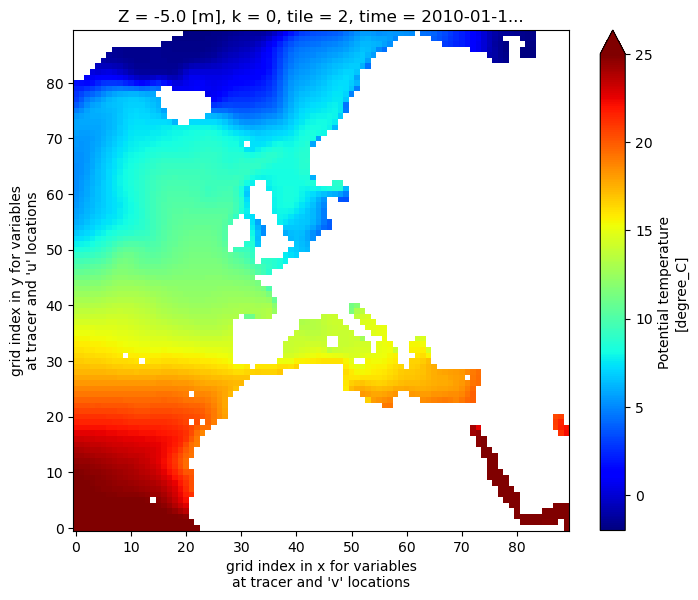

In [4]:
fig=plt.figure(figsize=(8, 6.5))
theta_dataset.THETA.isel(k=0,tile=2,time=0).plot(vmin=-2, vmax=25, cmap='jet')

## The Dimensions and Coordinates of *THETA*

Let's take a closer look at what is inside this dataset.  We suppress the metadata (attrs) just to reduce how much is printed to the screen.

In [5]:
theta_dataset.attrs = []
theta_dataset

<xarray.Dataset> Size: 510MB
Dimensions:    (time: 12, k: 50, tile: 13, j: 90, i: 90, nb: 4, j_g: 90,
                i_g: 90, nv: 2, k_l: 50, k_p1: 51, k_u: 50)
Coordinates: (12/22)
    XC         (tile, j, i) float32 421kB ...
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YC         (tile, j, i) float32 421kB ...
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    ...         ...
  * k_l        (k_l) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2010-01-16T12:00:00 ... 2010-12-16T1...
    time_bnds  (time, nv) datetime64[ns] 192B ...
Dimensions without coordinates: nb, nv
Data variables:
    SALT       (time, k, tile, j, i) float32 253MB ...
    THETA      (time, k, tile, j, i) float32 253MB ...

### Dimensions

*theta_dataset* shows 12 dimensions; recall that ``Dataset`` objects are containers and so it lists all of the  **unique** dimensions of the variables it is storing.  *theta_dataset* is storing two *Data variables*, *THETA* and *SALT*.  We see that these data variables are five dimensional from the dimension names within the parentheses, for example:
~~~
THETA      (time, tile, k, j, i) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
~~~
Examining the coordinates of the ``Dataset``, we find that all of them have some combination of the 12 dimensions.  Note *nv* is not a spatial or temporal dimension per se. It is a kind of dummy dimension of length 2 for the coordiante *time_bnds* which has both a starting and ending time for each one averaging period.  The same is true of *nb* which has length 4 and is used by *XC_bnds* and *YC_bnds* to store coordinates for the 4 corners of each tracer grid cell.

### Coordinates

#### Dimension Coordinates

Beyond having three spatial dimensions *theta_dataset* also has *coordinates* in the **i**, **j**, and **k** directions.  The most basic coordinates are 1D vectors, one for each dimension, which contain *indices* for the array.  Let us call these basic coordinates, *dimension coordinates*, whose names are indicated either by an asterisk or boldface in the dataset summary above.  Following Python convention, we use 0 as the first index of dimension coordinates:
```
  * i      (i)     int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g    (i_g)   int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j      (j)     int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g    (j_g)   int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k      (k)     int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u    (k_u)   int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l    (k_l)   int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1   (k_p1)  int32 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * tile   (tile)  int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time   (time)  datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
```

Let's examine the *centered* dimension coordinates more closely, i.e., `(i, j, k, tile, time)`. The latter part of this tutorial will discuss the spatial structure of dimension coordinates that are not centered on a tracer grid cell, e.g., `i_g`, `k_u`.

##### Dimension Coordinate ``i``

In [6]:
theta_dataset.i

<xarray.DataArray 'i' (i: 90)> Size: 360B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
      dtype=int32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
Attributes:
    axis:                   X
    comment:                In the Arakawa C-grid system, tracer (e.g., THETA...
    coverage_content_type:  coordinate
    long_name:              grid index in x for variables at tracer and 'v' l...
    swap_dim:               XC

*i* is an array of integers from 0 to 89 indicating the *x_grid_index* along this tile's *X* axis.

##### Dimension Coordinate ``j``

In [7]:
theta_dataset.j

<xarray.DataArray 'j' (j: 90)> Size: 360B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
      dtype=int32)
Coordinates:
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
Attributes:
    axis:                   Y
    comment:                In the Arakawa C-grid system, tracer (e.g., THETA...
    coverage_content_type:  coordinate
    long_name:              grid index in y for variables at tracer and 'u' l...
    swap_dim:               YC

*j* is an array of integers from 0 to 89 indicating the *y_grid_index* along this tile's *Y* axis.

##### Dimension Coordinate ``k``

In [8]:
theta_dataset.k

<xarray.DataArray 'k' (k: 50)> Size: 200B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int32)
Coordinates:
    Z        (k) float32 200B ...
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Attributes:
    axis:                   Z
    coverage_content_type:  coordinate
    long_name:              grid index in z for tracer variables
    swap_dim:               Z

*k* is an array of integers from 0 to 49 indicating the *z_grid_index* along this tile's *Z* axis.

##### Dimension Coordinate ``tile``

In [9]:
theta_dataset.tile

<xarray.DataArray 'tile' (tile: 13)> Size: 52B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)
Coordinates:
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:                The ECCO V4 horizontal model grid is divided into...
    coverage_content_type:  coordinate
    long_name:              lat-lon-cap tile index

*tile* is an array of integers from 0 to 12, one for each tile of the lat-lon-cap grid.

##### Dimension Coordinate ``time``

In [10]:
theta_dataset.time

<xarray.DataArray 'time' (time: 12)> Size: 96B
array(['2010-01-16T12:00:00.000000000', '2010-02-15T00:00:00.000000000',
       '2010-03-16T12:00:00.000000000', '2010-04-16T00:00:00.000000000',
       '2010-05-16T12:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2010-07-16T12:00:00.000000000', '2010-08-16T12:00:00.000000000',
       '2010-09-16T00:00:00.000000000', '2010-10-16T12:00:00.000000000',
       '2010-11-16T00:00:00.000000000', '2010-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 96B 2010-01-16T12:00:00 ... 2010-12-16T12:...
Attributes:
    axis:                   T
    bounds:                 time_bnds
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time

In this file the *time* coordinate indicates the *center time of the averaging period*.  Recall that we loaded the monthly-mean ``THETA`` fields for  2010, so the *center time of the averaging periods* are the middle of each month in 2010.

#### Other Coordinates

Notice some *coordinates* do not have an **"\*"** in front of their names:
```             
Coordinates:
    XC          (tile, j, i)              float32     dask.array<chunksize=(13, 90, 90), meta=n...
    YC          (tile, j, i)              float32     dask.array<chunksize=(13, 90, 90), meta=n...
    XG          (tile, j_g, i_g)          float32     dask.array<chunksize=(13, 90, 90), meta=n...
    YG          (tile, j_g, i_g)          float32     dask.array<chunksize=(13, 90, 90), meta=n...
    Z           (k)                       float32     dask.array<chunksize=(50,), meta=np.ndar...
    Zp1         (k_p1)                    float32     dask.array<chunksize=(51,), meta=np.ndar...
    Zu          (k_u)                     float32     dask.array<chunksize=(50,), meta=np.ndar...
    Zl          (k_l)                     float32     dask.array<chunksize=(50,), meta=np.ndar...
    time_bnds   (time, nv)         datetime64[ns]     dask.array<chunksize=(1, 2), meta=np.nda...
    XC_bnds     (tile, j, i, nb)          float32     dask.array<chunksize=(13, 90, 90, 4), meta...
    YC_bnds     (tile, j, i, nb)          float32     dask.array<chunksize=(13, 90, 90, 4), meta...
    Z_bnds      (k, nv)                   float32     dask.array<chunksize=(50, 2), meta=np.nd...
```

These are so-called [non-dimension coordinates](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#coordinates).  From the xarray documenation:

```
1. non-dimension coordinates are variables that [may] contain coordinate data, 
   but are not a dimension coordinate. 

2. They can be multidimensional ... and there is no relationship between 
   the name of a non-dimension coordinate and the name(s) of its dimension(s). 

3. Non-dimension coordinates can be useful for indexing or plotting; ...
```

Six of these non-dimension coordinates contain *horizontal* spatial coordinate data:

* **XC** and **YC**, the longitudes and latitudes of the 'c' points (centered on **tile**, **j**, and **i**)
* **XG** and **YG**, the longitudes and latitudes of the 'g' points (the "lower-left" corners of the tracer grid cells, centered on **tile**, **j_g**, and **i_g**)
* **XC_bnds** and **YC_bnds**, the longitudes and latitudes of *all* corners of each grid cell (with the extra **nb** dimension corresponding to the 4 corners of each grid cell)

Five of these non-dimension coordinates contain *vertical* spatial coordinate data:

* **Z**, the center depth of tracer grid cells (centered on **k**)
* **Zp1**, the outer depth bounds of the tracer grid cells (centered on **k_p1** with length 1 longer than the vertical length of the grid)
* **Zu**, the depth of the *bottom* of tracer grid cells (centered on **k_u**). Be careful, you might think *Zu* and *k_u* refer to the upper edge of the grid cell, but actually they refer to the upper edge of the *k* index, i.e., the bottom edge.
* **Zl**, the depth of the *top* of tracer grid cells (centered on **k_l**)
* **Z_bnds**, the depth bounds of each tracer grid cell (with the extra **nv** dimension of length 2 corresponding to 2 vertical bounds)

And one non-dimension coordinate contains time data: 

* **time_bnds**, a 1x2 array of calendar dates and times indicating the start and end times of the averaging period of the field

When multiple DataArrays from different times are combined, the dimensions of the merged arrays will expand along the **time** dimension.   

Let's quickly look at the **time_bnds** coordinate. The `.values` attribute provides the content of an xarray variable as a NumPy array, which is useful for examining data values as well as some numerical manipulations not allowed on xarray DataArrays.

In [11]:
theta_dataset.time_bnds.values

array([['2010-01-01T00:00:00.000000000', '2010-02-01T00:00:00.000000000'],
       ['2010-02-01T00:00:00.000000000', '2010-03-01T00:00:00.000000000'],
       ['2010-03-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000'],
       ['2010-04-01T00:00:00.000000000', '2010-05-01T00:00:00.000000000'],
       ['2010-05-01T00:00:00.000000000', '2010-06-01T00:00:00.000000000'],
       ['2010-06-01T00:00:00.000000000', '2010-07-01T00:00:00.000000000'],
       ['2010-07-01T00:00:00.000000000', '2010-08-01T00:00:00.000000000'],
       ['2010-08-01T00:00:00.000000000', '2010-09-01T00:00:00.000000000'],
       ['2010-09-01T00:00:00.000000000', '2010-10-01T00:00:00.000000000'],
       ['2010-10-01T00:00:00.000000000', '2010-11-01T00:00:00.000000000'],
       ['2010-11-01T00:00:00.000000000', '2010-12-01T00:00:00.000000000'],
       ['2010-12-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000']],
      dtype='datetime64[ns]')

For time-averaged fields, **time_bnds** is a 2D array provding the *start* and *end* time of each averaging period.  

Let's look at the third record (March, 2010)

In [12]:
theta_dataset.time_bnds[2].values

array(['2010-03-01T00:00:00.000000000', '2010-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

We see that the time bounds are 2010-03-01 to 2010-04-01, which make sense.
  
Having this time-bounds information readily available can be very helpful.

## The Dimension Coordinates of the Arakawa C-Grid

Dimension coordinates have special meanings.  The MITgcm uses the staggered Arakawa-C grid (hereafter c-grid). In c-grid models, variables are staggered in space.  Horizontally, variables are associated with three 'locations': 

1. tracer cells (e.g. temperature, salinity, density)
2. the 4 lateral faces of tracer cells (e.g., horizontal velocities and fluxes) 
3. the 4 corners of tracer cells (e.g., vertical component of vorticity field)

Vertically, there are also two 'locations': 

1. tracer cells
2. the 2 top/bottom faces of tracer cells (e.g., vertical velocities and fluxes).

To understand this better, let's review the geometry of c-grid models.

### 3D staggering of velocity components. 

Paraphrasing from https://mitgcm.readthedocs.io/en/latest/algorithm/c-grid.html,

~~~
In c-grid models, the components of flow (u,v,w) are staggered in 
space such that the zonal component falls on the interface between 
tracer cells in the zonal direction. Similarly for the meridional 
and vertical directions. 
~~~

#### Why the c-grid?

~~~
The basic algorithm employed for stepping forward the momentum 
equations is based on retaining non-divergence of the flow at 
all times. This is most naturally done if the components of flow
are staggered in space in the form of an Arakawa C grid...
~~~

![uvw-grid](../figures/uvw.png )


### Defining the c-grid coordinate system

As shown, variables on Arakawa-C grids (c-grid) are staggered in space.  For convenience we  define a coordinate system that distinguishes between these different locations.

#### The c-grid horizontal coordinates

In the horizontal, variables can take one of four locations: **c**, **u**, **v**, or **g**.  

![c-grid](../figures/C-grid-points.png )


##### horizontal "c" location

Variables associated with tracer cell area or volumetric averages (e.g., temperature, salinity, sea ice thickness, air-sea net heat flux) and variables associated with vertical velocities (e.g., $\vec w$) are identified with **c** locations.

For these variables we define the horizontal dimensions of **i** and **j**, corresponding with the model grid $x$ and $y$ directions, respectively.  

##### horizontal "u" location

Variables associated with the two lateral sides of tracer cells in the $x$ direction are identified with **u** locations. 

Define the horizontal dimensions of **u** variables as **i_g** and **j**, corresponding with the model's $x$ and $y$ dimensions, respectively.  

> **Important Note**: In the llc90 curvilinear model grid used by ECCOv4, the $x$ direction is **NOT** same as the geographic zonal (east-west) direction.

##### horizontal "v" location

Variables associated with the two lateral sides of tracer cells in the $y$ direction are identified with **v** locations. 

Define the horizontal dimensions of **v** variables as **i** and **j_g**, corresponding with the model's $x$ and $y$ dimensions, respectively.

> **Important Note**: In the llc90 curvilinear model grid used by ECCOv4, the $y$ direction is **NOT** same as the geographic meridional (north-south) direction.


##### horizontal "g" location

Variables associated with the horizontal corners of tracer grid cells are identified with **g** locations.

Define the horizontal dimensions of **g** variables as **i_g** and **j_g**, corresponding with the model's $x$ and $y$ dimensions, respectively.  

#### The c-grid vertical coordinates

In the horizontal, variables can take one of two locations: **c** and **w**

#### vertical "c" location

Variables associated with tracer cell volumetric quantities (e.g., temperature, salinity) are identified with **c** locations.

For these variables we define the vertical dimensions of **k** which corresponds with the model grid' $z$ direction.

#### vertical "w" location

Variables associated with the two top/bottom sides of tracer cells in the $z$ direction are identified with **w** locations. 

For these variables we define the vertical dimension of **$k_u$** to indicate the model tracer cell's **u**pper faces in the $k$ direction, i.e., the *bottom* faces of the cell.  

Two other vertical dimensions are also used.  **$k_l$** indicates the model tracer cell's **l**ower faces in the $k$ direction (i.e., the *top* faces of the cell), and $k_{p1}$ which index all of the **upper** and **lower** faces.  

> Note: In ECCOv4 NetCDF files both **$k_l$**(0) and **$k_{p1}$**(0) correspond to the same top face of the model tracer grid cell.

## All ECCOv4 coordinates

Now that we have been oriented to the dimensions and coordinates used by ECCOv4, let's examine a ``Dataset`` that uses all of them, an ECCOv4r4 NetCDF grid file. The grid file for the native LLC90 grid has ShortName **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**. It does not have time dimensions, but we can put any StartDate and EndDate between 1992-01-01 and 2018-01-01 into the `ecco_access` functions and it should retrieve the file. Then the file can be opened, and in this case we will also use `.compute()` to load the file's data into memory since it is not that large.

In [13]:
## download file containing grid parameters and load into workspace

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"]
grid_dataset = ea.ecco_podaac_access_to_xrdataset(ShortNames_list,\
                                                  StartDate=StartDate,EndDate=EndDate,\
                                                  mode=access_mode,\
                                                  download_root_dir=ECCO_dir,\
                                                  max_avail_frac=0.5,\
                                                  jsons_root_dir=jsons_root_dir).compute()

Open the ECCOv4r4 grid file:

In [14]:
# show contents of grid_dataset
grid_dataset

<xarray.Dataset> Size: 89MB
Dimensions:  (tile: 13, j: 90, i: 90, k: 50, k_p1: 51, nb: 4, j_g: 90, i_g: 90,
              nv: 2, k_l: 50, k_u: 50)
Coordinates: (12/20)
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    XC_bnds  (tile, j, i, nb) float32 2MB -115.0 -115.0 -107.9 ... -115.0 -108.5
    XG       (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    YC_bnds  (tile, j, i, nb) float32 2MB -88.18 -88.32 -88.3 ... -88.18 -88.16
    YG       (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    ...       ...
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_l      (k_l) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_p1     (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49 50
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 421kB 0.06158 0.06675 ... -0.9854 -0.9984
    Depth    (tile, j, i) float32 421kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PHrefC   (k) float32 200B 49.05 147.1 245.2 ... 5.357e+04 5.794e+04
    PHrefF   (k_p1) float32 204B 0.0 98.1 196.2 ... 5.145e+04 5.57e+04 6.018e+04
    SN       (tile, j, i) float32 421kB -0.9981 -0.9978 ... -0.1705 -0.05718
    drC      (k_p1) float32 204B 5.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
    ...       ...
    maskS    (k, tile, j_g, i) bool 5MB False False False ... False False False
    maskW    (k, tile, j, i_g) bool 5MB False False False ... False False False
    rA       (tile, j, i) float32 421kB 3.623e+08 3.633e+08 ... 3.611e+08
    rAs      (tile, j_g, i) float32 421kB 1.802e+08 1.807e+08 ... 3.605e+08
    rAw      (tile, j, i_g) float32 421kB 3.617e+08 3.628e+08 ... 3.648e+08
    rAz      (tile, j_g, i_g) float32 421kB 1.799e+08 1.805e+08 ... 3.642e+08
Attributes: (12/58)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

You'll notice that the dimensions and coordinates of the grid file are the same as for the potential temperature/salinity files we looked at before, except that there is no time dimension or time-related coordinates.  Let's move on to the **Data variables**, which in this file are parameters associated with the grid.


### Grid Parameters

There are 21 data variables in the grid file.  These grid parameters describe the model grid geometry, and are essential for quantitative analysis with ECCO output.

axis rotation factors:
```
    CS       (tile, j, i)   float32 ...
    SN       (tile, j, i)   float32 ...
```

horizontal distances:
```
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    dxC      (tile, j, i_g) float32 ...
    dyC      (tile, j_g, i) float32 ...
```

vertical distances:
```
    drC      (k_p1) float32 ...
    drF      (k) float32 ...
```        

areas:
```
    rA       (tile, j, i) float32 ...
    rAz      (tile, j_g, i_g) float32 ...
    rAw      (tile, j, i_g) float32 ...
    rAs      (tile, j_g, i) float32 ...
```

reference hydrostatic pressure at cell depth:
```
    PHrefC   (k) float32 ...
    PHrefF   (k_p1) float32 ...
```

partial cell fractions:
```
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
```

wet/dry boolean masks:
```
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
```

seafloor depth:
```
Depth    (j, i) float32 ...
```



Grid parameters are not coordinates in the sense that they help you orient in space or time, but they provide measures of the model grid such as distances and areas.  Let's examine one of these grid geometric variables, *dxG*:

In [15]:
grid_dataset.dxG

<xarray.DataArray 'dxG' (tile: 13, j_g: 90, i: 90)> Size: 421kB
array([[[ 15584.907 ,  15589.316 ,  15593.201 , ...,   7873.7295,
           7446.052 ,   7004.153 ],
        [ 15588.651 ,  15593.048 ,  15596.92  , ...,   7888.4585,
           7461.8286,   7021.1333],
        [ 15600.185 ,  15604.543 ,  15608.381 , ...,   7933.642 ,
           7510.2056,   7073.169 ],
        ...,
        [ 57957.625 ,  57957.625 ,  57957.625 , ...,  57957.625 ,
          57957.625 ,  57957.625 ],
        [ 58813.305 ,  58813.305 ,  58813.305 , ...,  58813.305 ,
          58813.305 ,  58813.305 ],
        [ 59676.61  ,  59676.61  ,  59676.61  , ...,  59676.61  ,
          59676.61  ,  59676.61  ]],

       [[ 60542.324 ,  60542.324 ,  60542.324 , ...,  60542.324 ,
          60542.324 ,  60542.324 ],
        [ 61409.805 ,  61409.805 ,  61409.805 , ...,  61409.805 ,
          61409.805 ,  61409.805 ],
        [ 62279.344 ,  62279.344 ,  62279.344 , ...,  62279.344 ,
          62279.344 ,  62279.344 ],
...
        [108086.08  , 106469.66  , 103581.64  , ...,  60816.504 ,
          59953.41  ,  59441.125 ],
        [108086.08  , 106469.66  , 103581.64  , ...,  60816.504 ,
          59953.41  ,  59441.125 ],
        [108086.08  , 106469.66  , 103581.64  , ...,  60816.504 ,
          59953.41  ,  59441.125 ]],

       [[ 58963.117 ,  58455.164 ,  57611.023 , ...,   6833.7446,
           6639.343 ,   6479.438 ],
        [ 58963.117 ,  58455.164 ,  57611.023 , ...,   6347.175 ,
           6156.099 ,   6002.6626],
        [ 58963.117 ,  58455.164 ,  57611.023 , ...,   5857.2334,
           5668.565 ,   5521.185 ],
        ...,
        [ 58963.117 ,  58455.164 ,  57611.023 , ...,  23901.465 ,
          23445.639 ,  22990.21  ],
        [ 58963.117 ,  58455.164 ,  57611.023 , ...,  23982.959 ,
          23525.693 ,  23068.766 ],
        [ 58963.117 ,  58455.164 ,  57611.023 , ...,  24059.047 ,
          23600.436 ,  23142.107 ]]], dtype=float32)
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    comment:                Alternatively, the length of 'south' side of trac...
    coordinate:             YG XC
    coverage_content_type:  modelResult
    long_name:              distance between 'southwest' and 'southeast' corn...
    units:                  m

``dxG`` has coordinates **tile**, **j_g** and **i** which means that it is a **v** location variable.  ``dxG`` is the horizontal distance between $g$ points (tracer cell corners) in the tile's $x$ direction.  

For reference, see the chart below from the MITgcm documentation, [Figure 2.6](https://mitgcm.readthedocs.io/en/latest/algorithm/horiz-grid.html "Fig 2.6")

dxG = $\Delta x_g$ in subfigure (a) below:

![hgrid](../figures/hgrid-abcd.svg)

*Figure 2.6 Staggering of horizontal grid descriptors (lengths and areas). The grid lines indicate the tracer cell boundaries and are the reference grid for all panels. a) The area of a tracer cell, 𝐴𝑐, is bordered by the lengths Δ𝑥𝑔 and Δ𝑦𝑔. b) The area of a vorticity cell, 𝐴𝜁, is bordered by the lengths Δ𝑥𝑐 and Δ𝑦𝑐. c) The area of a u cell, 𝐴𝑤, is bordered by the lengths Δ𝑥𝑣 and Δ𝑦𝑓. d) The area of a v cell, 𝐴𝑠, is bordered by the lengths Δ𝑥𝑓 and Δ𝑦𝑢.*

## Dimensions and Coordinates of Velocities

So far we looked at files with *THETA* and *SALT* which are $c$ variables (i.e. tracers).  Let's examine *UVEL*, horizontal velocity in the tile's $x$ direction.  As you've probably guessed, *UVEL* is a $u$ variable: 

Let's download and open the March 2010 mean horizontal velocity.

In [16]:
## download file containing monthly mean ocean velocities for March 2010, and load into workspace

ShortNames_list = ["ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"]
vel_dataset = ea.ecco_podaac_access_to_xrdataset(ShortNames_list,\
                                                 StartDate='2010-03',EndDate='2010-03',\
                                                 mode=access_mode,\
                                                 download_root_dir=ECCO_dir,\
                                                 max_avail_frac=0.5,\
                                                 jsons_root_dir=jsons_root_dir).compute()

In [17]:
# remove attributes from file and look at the file contents
vel_dataset.attrs = []
vel_dataset

<xarray.Dataset> Size: 68MB
Dimensions:    (time: 1, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
                k_l: 50, nb: 4, nv: 2, k_p1: 51, k_u: 50)
Coordinates: (12/22)
    XC         (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    XC_bnds    (tile, j, i, nb) float32 2MB -115.0 -115.0 ... -115.0 -108.5
    XG         (tile, j_g, i_g) float32 421kB -115.0 -115.0 ... -102.9 -109.0
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    YC_bnds    (tile, j, i, nb) float32 2MB -88.18 -88.32 ... -88.18 -88.16
    YG         (tile, j_g, i_g) float32 421kB -88.18 -88.32 ... -87.99 -88.02
    ...         ...
  * k_l        (k_l) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 8B 2010-03-16T12:00:00
    time_bnds  (time, nv) datetime64[ns] 16B 2010-03-01 2010-04-01
Dimensions without coordinates: nb, nv
Data variables:
    UVEL       (time, k, tile, j, i_g) float32 21MB nan nan nan ... nan nan nan
    VVEL       (time, k, tile, j_g, i) float32 21MB nan nan nan ... nan nan nan
    WVEL       (time, k_l, tile, j, i) float32 21MB nan nan nan ... nan nan nan

Notice that each of the velocity variables are centered at different locations, and none of them are at the center of the grid cell (k, tile, j, i).  ``UVEL`` has the **i_g** dimension, indicating that it is on the edge of each tracer cell along the $i$ axis.  ``VVEL`` has the **j_g** dimension, indicating that it is on the edge of each tracer cell along the $j$ axis.  ``WVEL`` has the **k_l** dimension, indicating that it is on the edge of each tracer cell along the $k$ (vertical) axis. 

Let's confirm this by looking at the dimensions and coordinates of each of the velocity files.

### ``UVEL``

In [18]:
vel_dataset.UVEL.dims

('time', 'k', 'tile', 'j', 'i_g')

In [19]:
vel_dataset.UVEL.coords

Coordinates:
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2010-03-16T12:00:00

Plot tile 1 time-mean horizontal velocity in the tile's $x$ direction, at the top-most model grid cell.

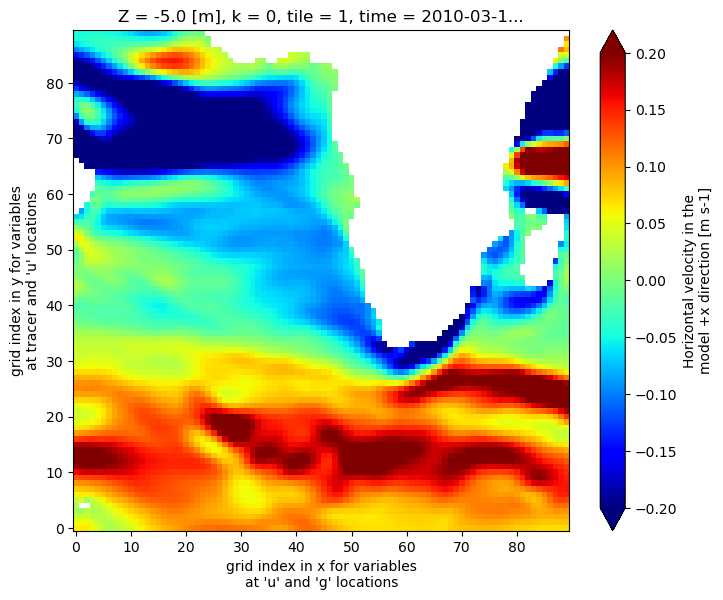

In [20]:
fig=plt.figure(figsize=(8, 6.5))
ud_masked = vel_dataset.UVEL.where(grid_dataset.hFacW > 0, np.nan)
ud_masked.isel(k=0,tile=1,time=0).plot(cmap='jet', vmin=-.2,vmax=.2)

### ``VVEL``

In [21]:
vel_dataset.VVEL.dims

('time', 'k', 'tile', 'j_g', 'i')

In [22]:
vel_dataset.VVEL.coords

Coordinates:
    Z        (k) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2010-03-16T12:00:00

Plot the time-mean horizontal velocity in the tile's $y$ direction, at the top-most model grid cell.

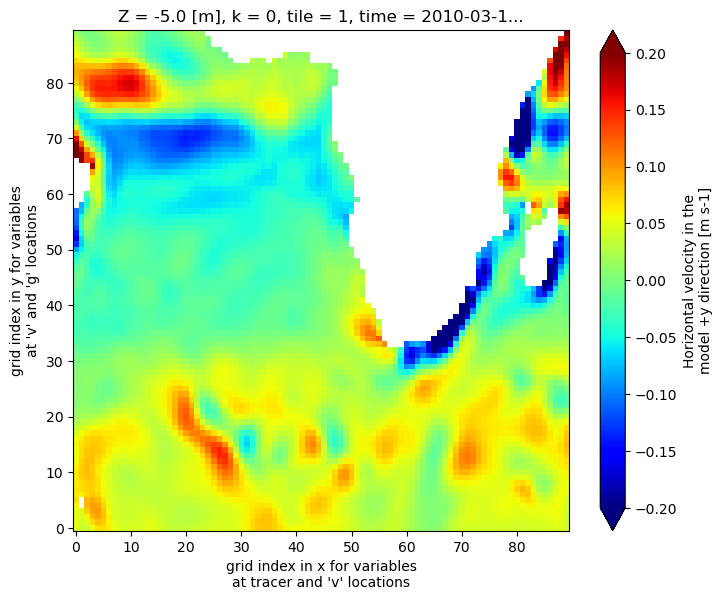

In [23]:
fig=plt.figure(figsize=(8, 6.5))
vd_masked = vel_dataset.VVEL.where(grid_dataset.hFacS > 0, np.nan)
vd_masked.isel(k=0,tile=1,time=0).plot(cmap='jet', vmin=-.2,vmax=.2)

### ``WVEL``

In [24]:
vel_dataset.WVEL.dims

('time', 'k_l', 'tile', 'j', 'i')

In [25]:
vel_dataset.WVEL.coords

Coordinates:
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Zl       (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k_l      (k_l) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 8B 2010-03-16T12:00:00

Plot the time-mean vertical velocity on the tile, at the ocean surface.  Note that the vertical index we pass to `isel` is ```k_l=0``` rather than ```k=0```, corresponding to the vertical dimension and coordinate of `WVEL`.

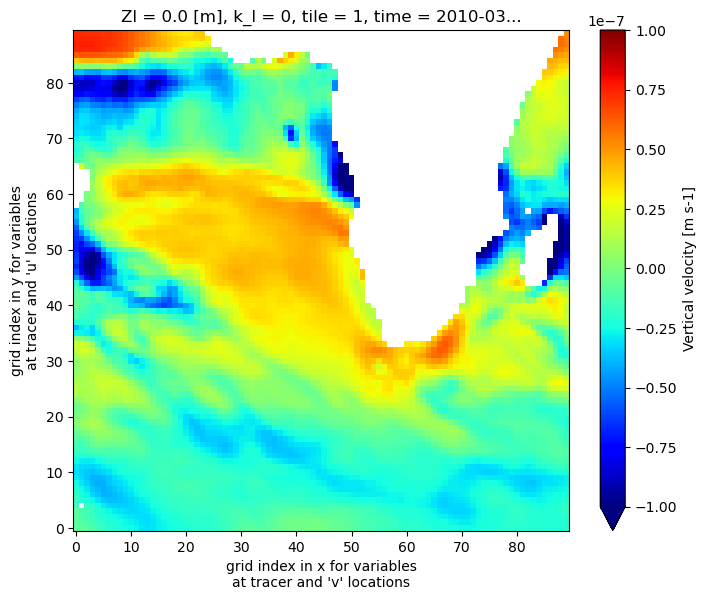

In [26]:
fig=plt.figure(figsize=(8, 6.5))
# use .values attribute below to avoid xarray getting confused about the different vertical dimensions (k_l vs. k)
wd_masked = vel_dataset.WVEL.where(grid_dataset.hFacC.values > 0, np.nan)
wd_masked.isel(k_l=0,tile=1,time=0).plot(cmap='jet', vmin=-1.e-7,vmax=1.e-7)

## Summary

ECCOv4 variables are on the staggered Arakawa-C grid.  Different dimension labels and coordinates are applied to state estimate variables so that one can easily identify where on the c-grid any particular variable is situated.
